<a href="https://colab.research.google.com/github/JuneFire/AI-Learning-With-Python/blob/master/Unet/TGS_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm
!pip install tqdm==4.54.1
!pip install scikit-image
!pip install tensorflow
!pip install keras

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 269 kB 13.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=37c7cce36c72daa9f0ef35f9fdfb6d9687ce857a487d359156907430832e490b
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyyaml
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


** 本地环境实在是难配置，我放弃了，还是用这个吧 ：）**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [ ]:
# 解压文件
import zipfile
zip_file = zipfile.ZipFile("train.zip")
zip_list = zip_file.namelist() # 得到压缩包里所有文件

for f in zip_list:
    zip_file.extract(f, "train") # 循环解压文件到指定目录
 
zip_file.close() # 关闭文件，必须有，释放内存

In [ ]:
# 读取训练图片
ids = next(os.walk("train/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))
print(ids)

No. of images =  4000
['9d98768f19.png', '6e691f1825.png', 'd62ad254c6.png', 'a913c2fc19.png', '70b6a2347f.png', 'f724f78b1a.png', 'cdf9422054.png', '690281a93d.png', '3507f73405.png', 'da082ec985.png', '4d04dcd959.png', '346358e652.png', 'f70f3b7b95.png', '8fd4178b11.png', '54842b574a.png', 'c67832ba86.png', 'dea0a56bab.png', 'ff238df1c4.png', 'e82421363e.png', 'c7ab9848b9.png', '7f5914b74a.png', '92d116836e.png', '576fd5de16.png', '9e7d89d4c0.png', '964030c032.png', '4e47ff086f.png', '20658e781f.png', 'd31c506913.png', 'a531b78648.png', '3c1ed5cc1f.png', '7ba58ee1be.png', '4514d46495.png', 'ce15cc1d1a.png', '62f822b156.png', '8c8c2012e7.png', 'd7f48d294e.png', '67db09fda5.png', '77415e7cda.png', 'cb677fab7a.png', '0a1742c740.png', 'a93c251217.png', 'c82f7676ac.png', '5187e13789.png', '16b2119ffa.png', '19e749d0b1.png', 'b9614348f4.png', '63193879b4.png', 'fff987cdb3.png', '1277f1a611.png', '114d62da56.png', '93a0cb5111.png', 'ce0e9def63.png', '829ebfbb32.png', '3a068284ed.png', 'b3b3

In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

## 加载图像和掩模

在图像目录中，有4000个地震图像被人类专家用来预测该区域是否存在盐沉积物。

在掩模目录中，有4000个灰度图像，它们是相应图像的实际地面实况值，表示地震图像是否包含盐沉积，如果是，则表示在哪里。 这些将用于建立监督学习模型。

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("train/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("train/masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/venv/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Below code can be used to visualize the images and corresponding masks¶

左边的图像是地震图像。 绘制黑色边界只是为了理解表示哪个部分包含盐而哪个部分不包含盐。 （当然这个边界不是原始图像的一部分）

右边的图像称为掩膜，它是地面实况标签。 这就是我们的模型必须为给定的地震图像预测的。 白色区域表示盐沉积，黑色区域表示无盐。

如果掩模是完全黑色的，这意味着给定的地震图像中没有盐沉积物。

Text(0.5, 1.0, 'Salt')

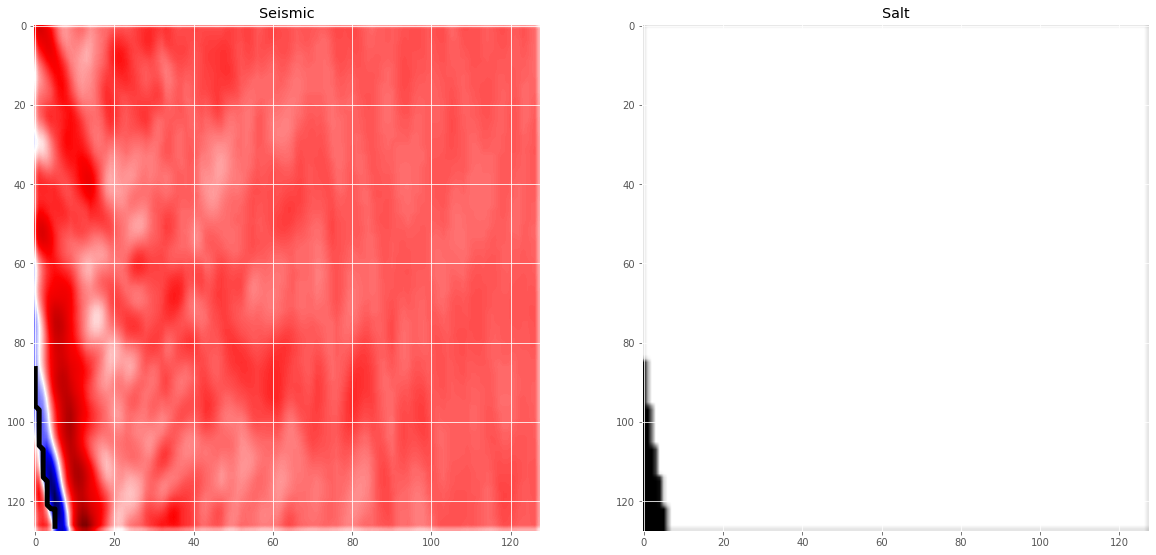

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

卷积操作

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

UNET

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

使用Adam优化器编译模型，我们使用二元交叉熵损失函数，因为只有两个类（盐和无盐）。

我们使用Keras回调来实现：

如果5个连续时期的验证损失没有改善，则学习率会下降。
如果10个连续时期的验证损失没有改善，则提前停止。
仅在验证损失有所改善时保存权重。
我们使用批量大小为32。

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: -181.3525 - accuracy: 0.4925
Epoch 00001: val_loss improved from inf to -874.07623, saving model to model-tgs-salt.h5
113/113 [==============================] - 448s 4s/step - loss: -181.3525 - accuracy: 0.4925 - val_loss: -874.0762 - val_accuracy: 0.1425
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: -396.9755 - accuracy: 0.2078
Epoch 00002: val_loss improved from -874.07623 to -1559.69482, saving model to model-tgs-salt.h5
113/113 [==============================] - 446s 4s/step - loss: -396.9755 - accuracy: 0.2078 - val_loss: -1559.6948 - val_accuracy: 0.3119
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: -673.0764 - accuracy: 0.1755
Epoch 00003: val_loss did not improve from -1559.69482
113/113 [==============================] - 444s 4s/step - loss: -673.0764 - accuracy: 0.1755 - val_loss: -1186.7352 - val_accuracy: 0.5466
Epoch 4/50
113/113 [==========================

113/113 [==============================] - ETA: 0s - loss: -2506.4871 - accuracy: 0.1216
Epoch 00007: val_loss improved from -2869.37524 to -3338.50684, saving model to model-tgs-salt.h5
113/113 [==============================] - 453s 4s/step - loss: -2506.4871 - accuracy: 0.1216 - val_loss: -3338.5068 - val_accuracy: 0.1859
Epoch 8/50
113/113 [==============================] - ETA: 0s - loss: -3154.1934 - accuracy: 0.1089
Epoch 00008: val_loss improved from -3338.50684 to -6257.78564, saving model to model-tgs-salt.h5
113/113 [==============================] - 444s 4s/step - loss: -3154.1934 - accuracy: 0.1089 - val_loss: -6257.7856 - val_accuracy: 0.0271
Epoch 9/50
113/113 [==============================] - ETA: 0s - loss: -3858.0386 - accuracy: 0.1114
Epoch 00009: val_loss did not improve from -6257.78564
113/113 [==============================] - 446s 4s/step - loss: -3858.0386 - accuracy: 0.1114 - val_loss: -4661.5679 - val_accuracy: 0.1680
Epoch 10/50
113/113 [===================

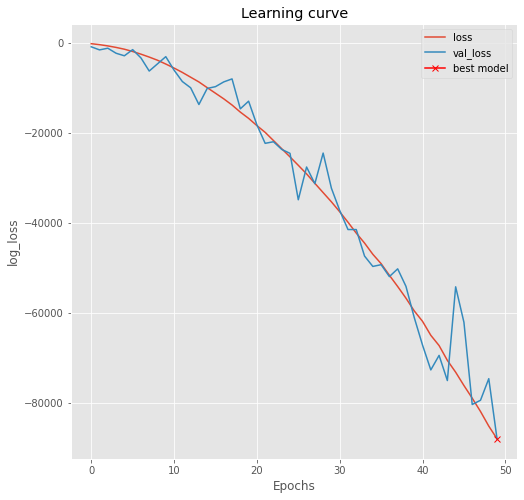

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();



对于每个像素，我们得到一个介于0到1之间的值。
0表示无盐，1表示盐。
我们将0.5作为阈值来决定是否将像素分类为0或1。

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 9s 706ms/step - loss: -88018.3281 - accuracy: 0.2797


[-88018.328125, 0.27974259853363037]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 9s 697ms/step


In [1]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

NameError: name 'preds_train' is not defined

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');


Predictions on training set

训练集上的验证结果


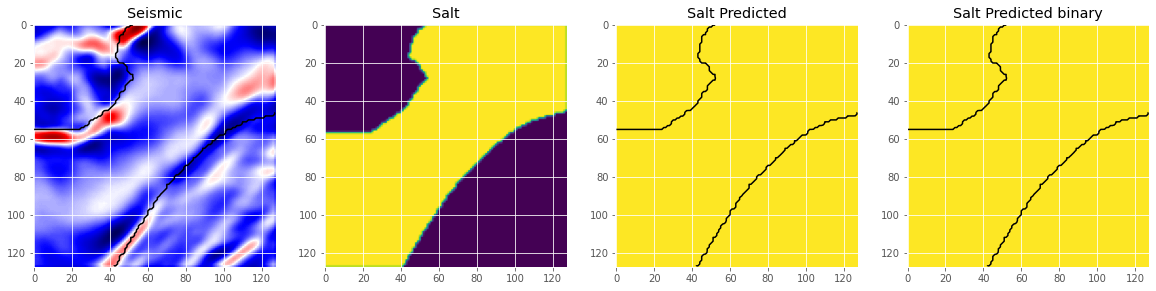

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

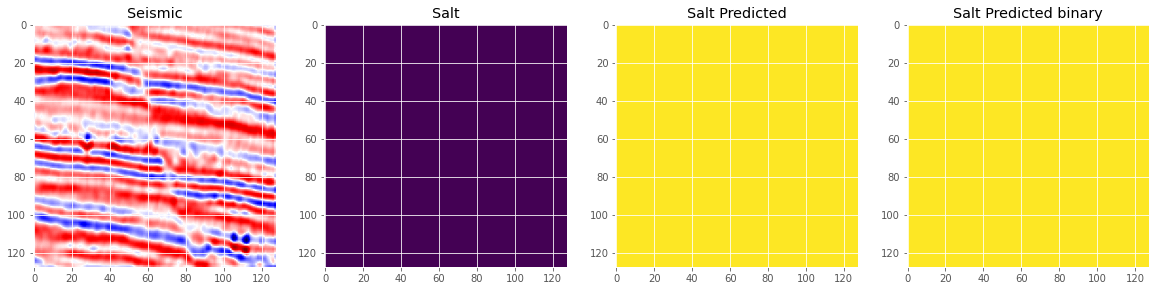

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

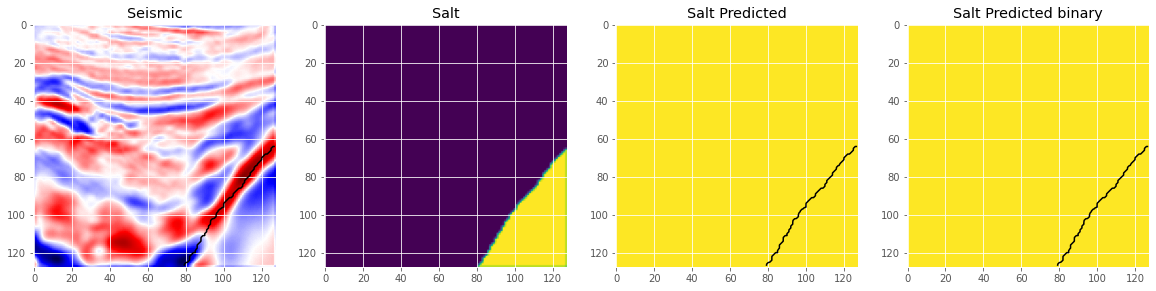

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

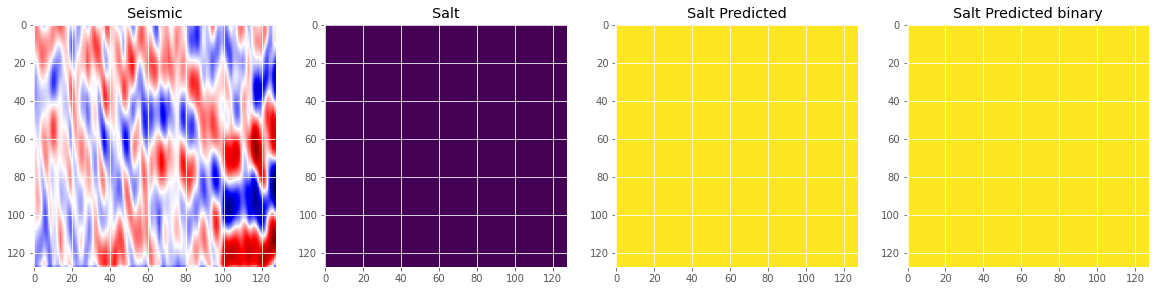

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Predictions on test set

验证集上的验证结果

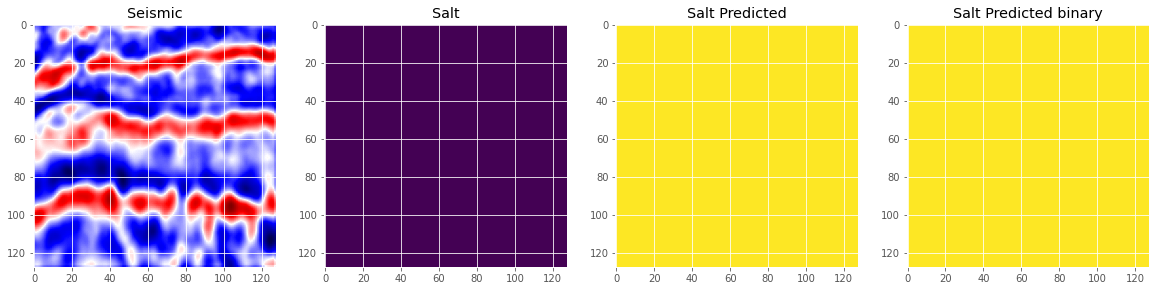

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

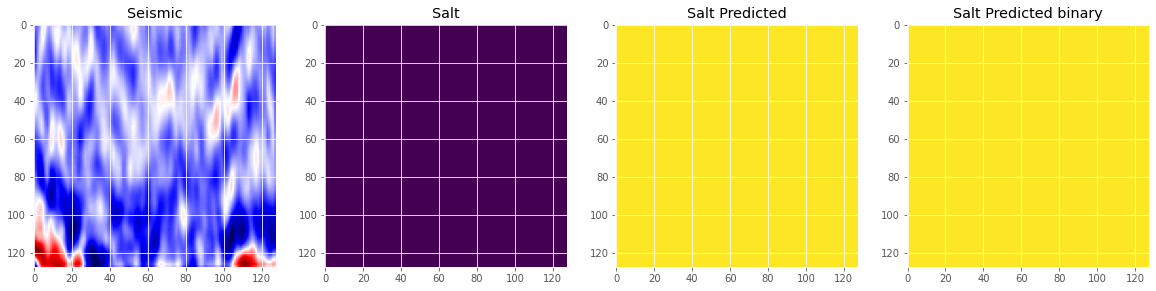

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

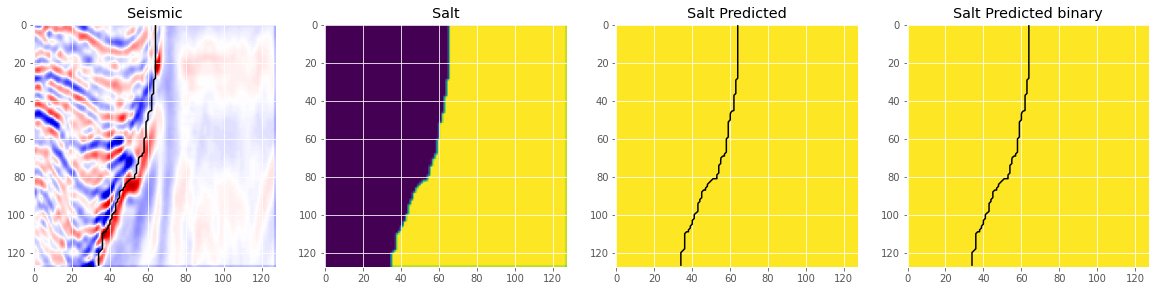

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

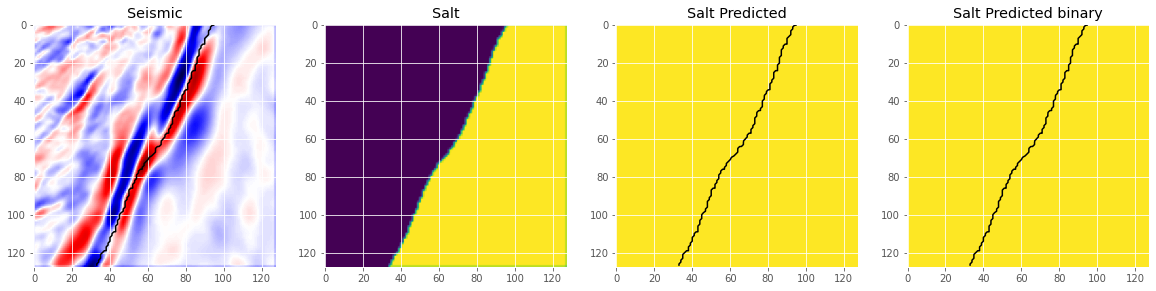

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)